In [2]:
import random
import numpy as np
from PIL import Image
from plots import plot_images
from utils import train_step, val_step, Plot_ROC

import torch, torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from torchvision.transforms import Compose, Normalize
from helpers import index_splitter, make_balanced_sampler
from StepByStep import StepByStep

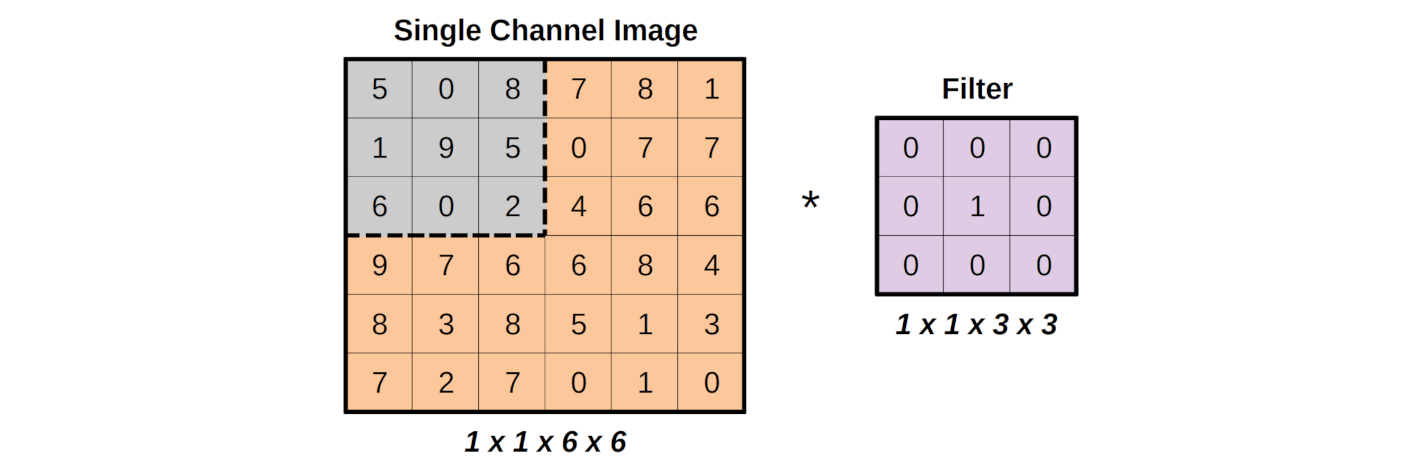

In [3]:
single = np.array(
    [[[[5, 0, 8, 7, 8, 1],
       [1, 9, 5, 0, 7, 7],
       [6, 0, 2, 4, 6, 6],
       [9, 7, 6, 6, 8, 4],
       [8, 3, 8, 5, 1, 3],
       [7, 2, 7, 0, 1, 0]]]]
)
single.shape

(1, 1, 6, 6)

In [4]:
identity = np.array(
    [[[[0, 0, 0],
       [0, 1, 0],
       [0, 0, 0]]]]
)
identity.shape

(1, 1, 3, 3)

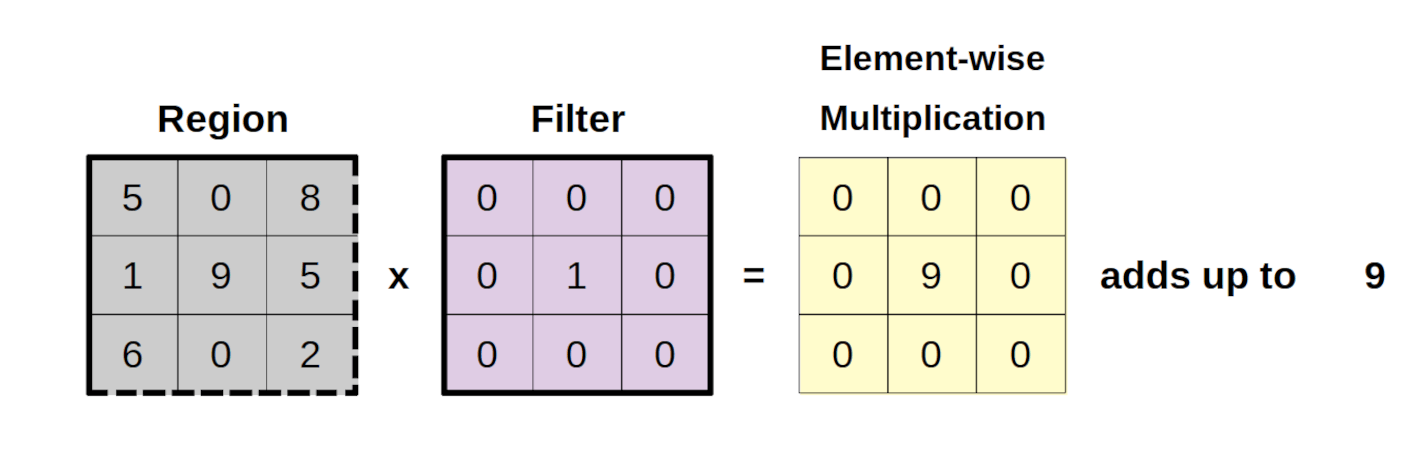

In [5]:
region = single[:, :, 0:3, 0:3]
filtered_region = region * identity
total = filtered_region.sum()
total

9

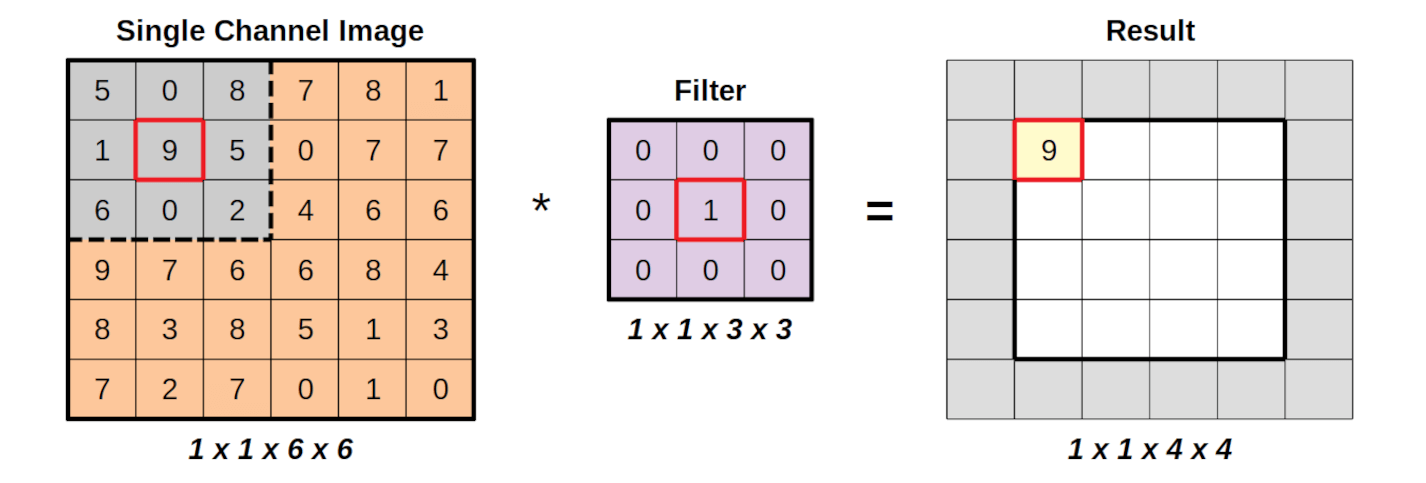

### **Moving Around**
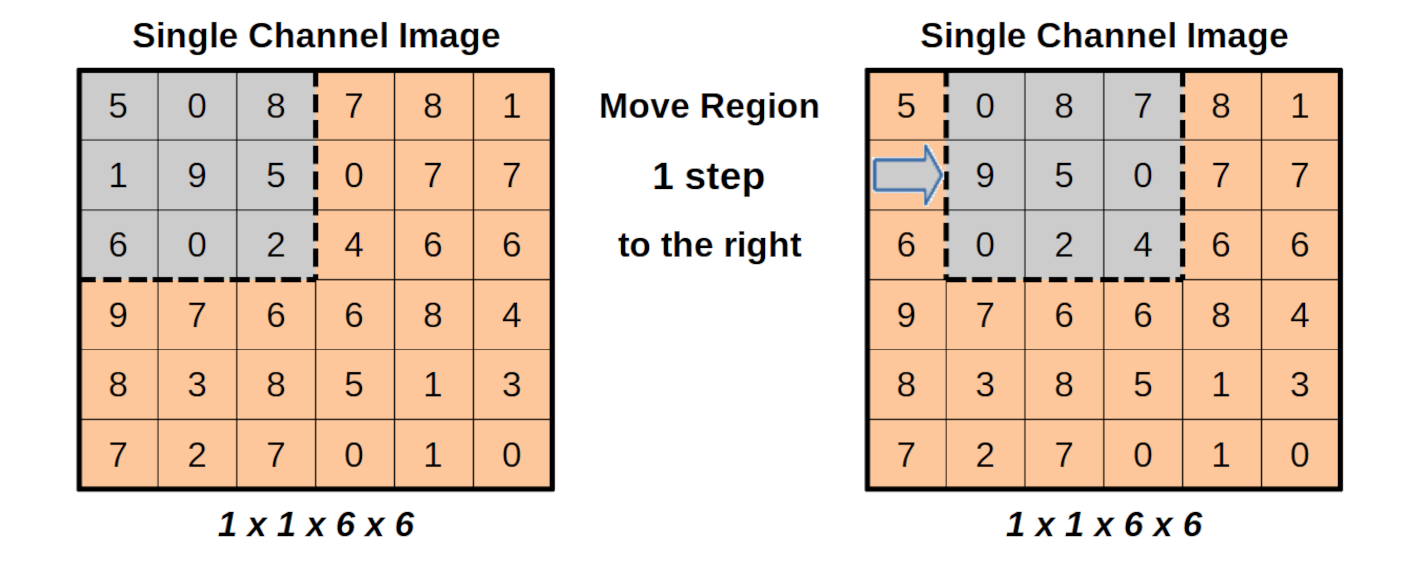

In [6]:
new_region = single[:, :, 0:3, (0+1):(3+1)]

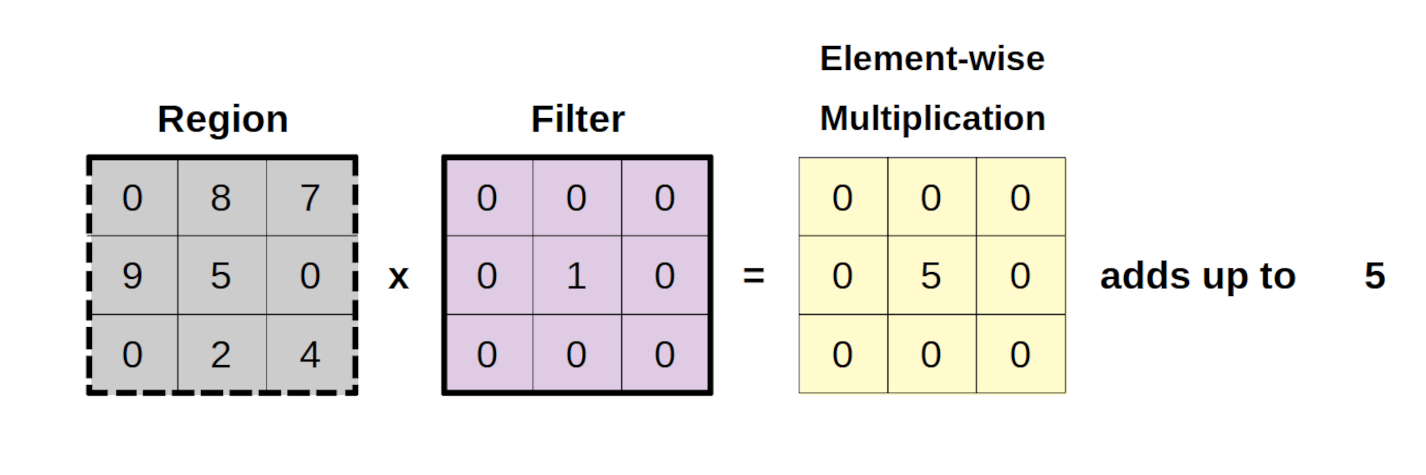

In [7]:
new_filtered_region = new_region * identity
new_total = new_filtered_region.sum()
new_total

5

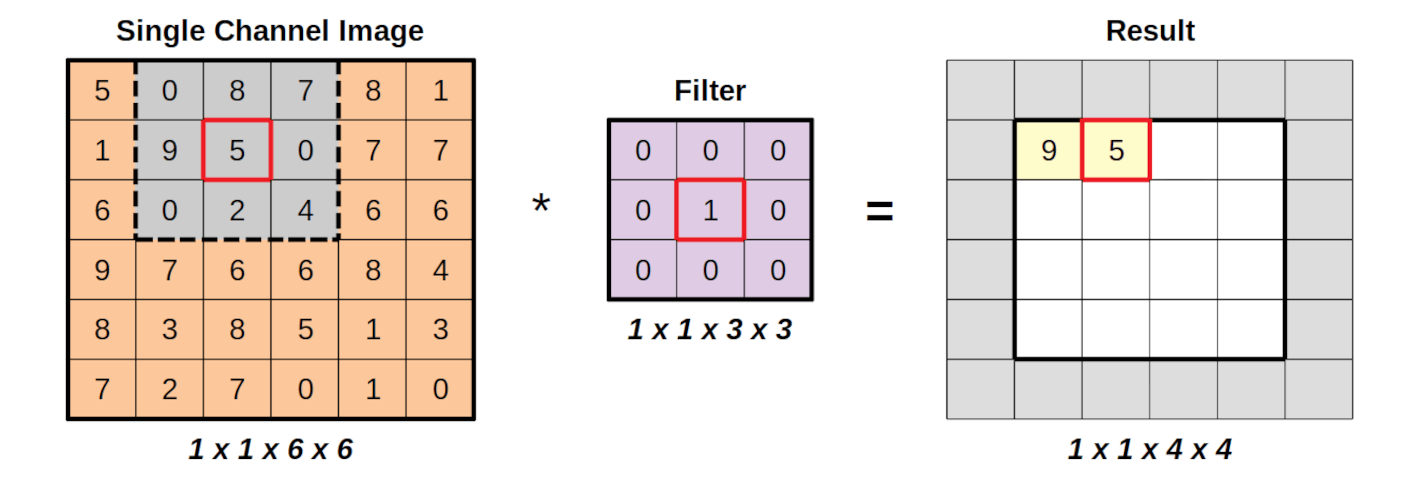

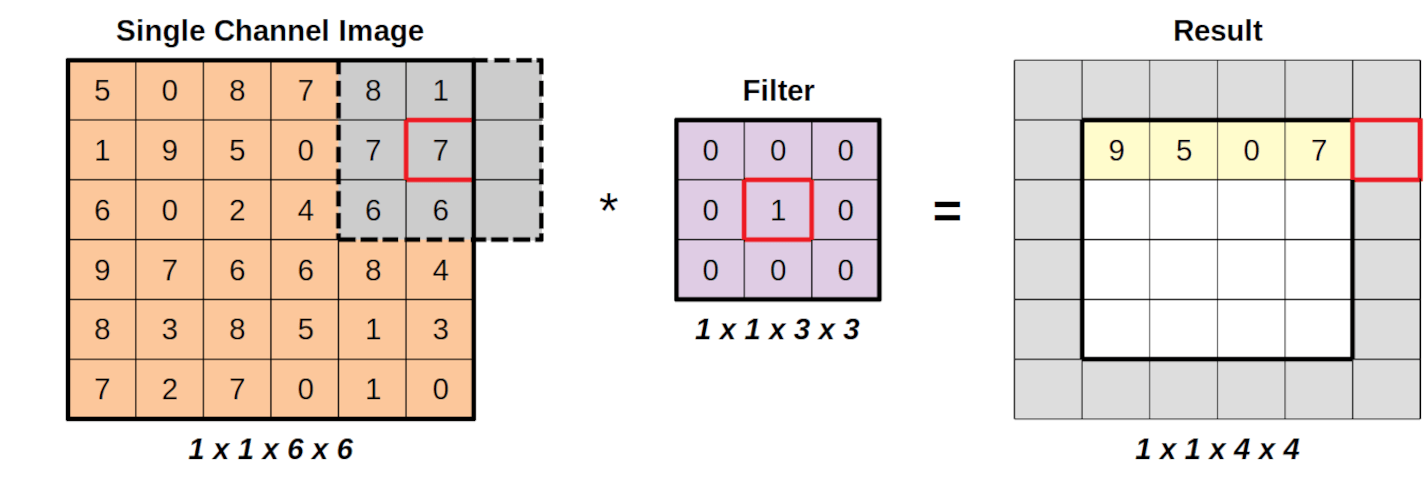

In [8]:
last_horizontal_region = single[:, :, 0:3, (0+4):(3+4)]

## **Shape**

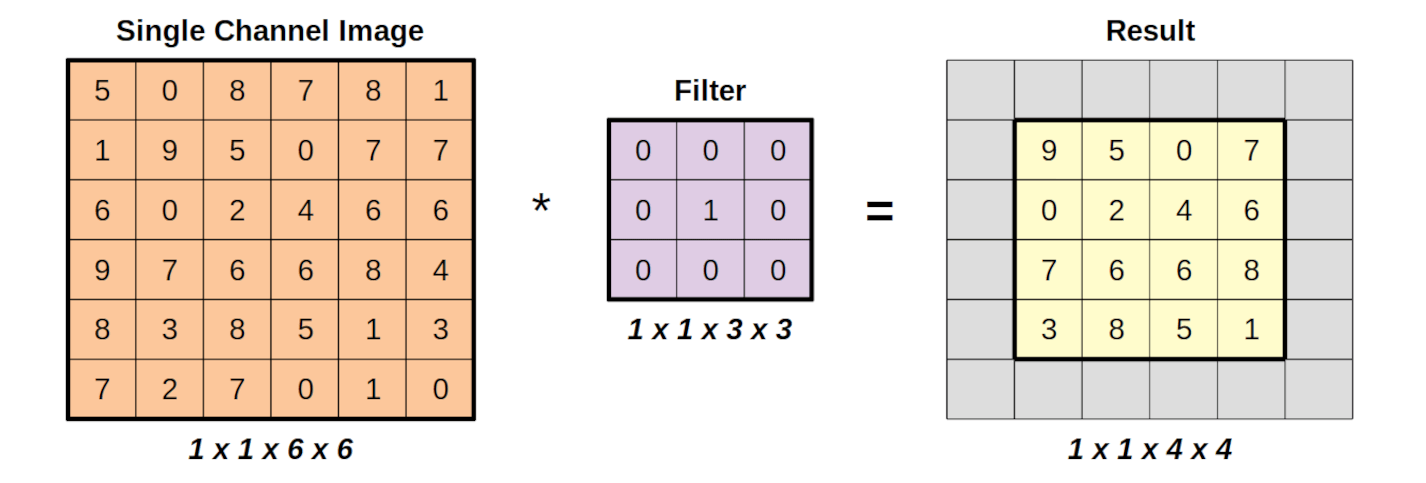

## **Convolving in PyTorch**

In [10]:
image = torch.as_tensor(single).float()
kernel_identity = torch.as_tensor(identity).float()

In [11]:
convolved = F.conv2d(image, kernel_identity, stride=1)
convolved

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]])

In [12]:
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1)
conv(image)

tensor([[[[ 2.1686,  3.7333,  0.8983,  0.4145],
          [ 1.5427, -1.1996,  1.3249,  1.9910],
          [-0.9658,  0.0801, -0.4485,  2.0117],
          [ 0.0602, -0.0926,  1.4853,  0.0624]]]],
       grad_fn=<ConvolutionBackward0>)

In [13]:
conv_multiple = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1)
conv_multiple.weight

Parameter containing:
tensor([[[[-0.0091,  0.2888, -0.1048],
          [-0.1547, -0.3093,  0.2350],
          [-0.1161, -0.2544,  0.0039]]],


        [[[-0.1937,  0.0667,  0.2596],
          [-0.1336,  0.0188,  0.0053],
          [-0.1007, -0.1990, -0.2218]]]], requires_grad=True)

In [14]:
with torch.no_grad():
    conv.weight[0] = kernel_identity
    conv.bias[0] = 0

In [15]:
conv(image)

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]], grad_fn=<ConvolutionBackward0>)

## **Striding**

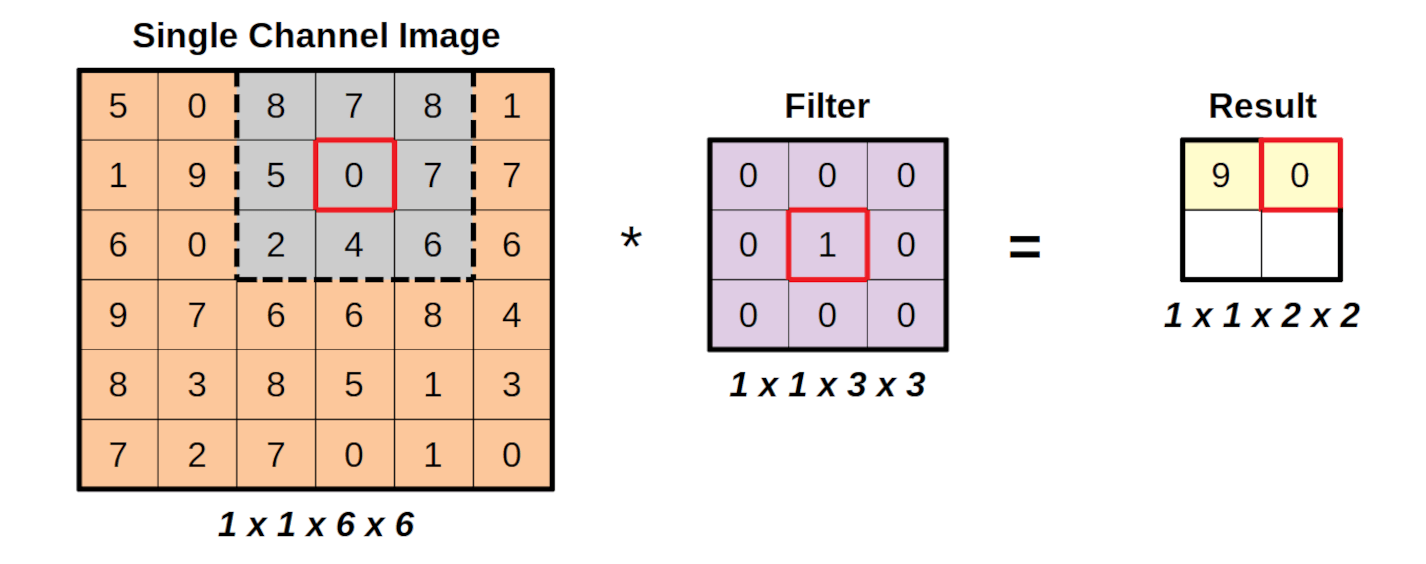

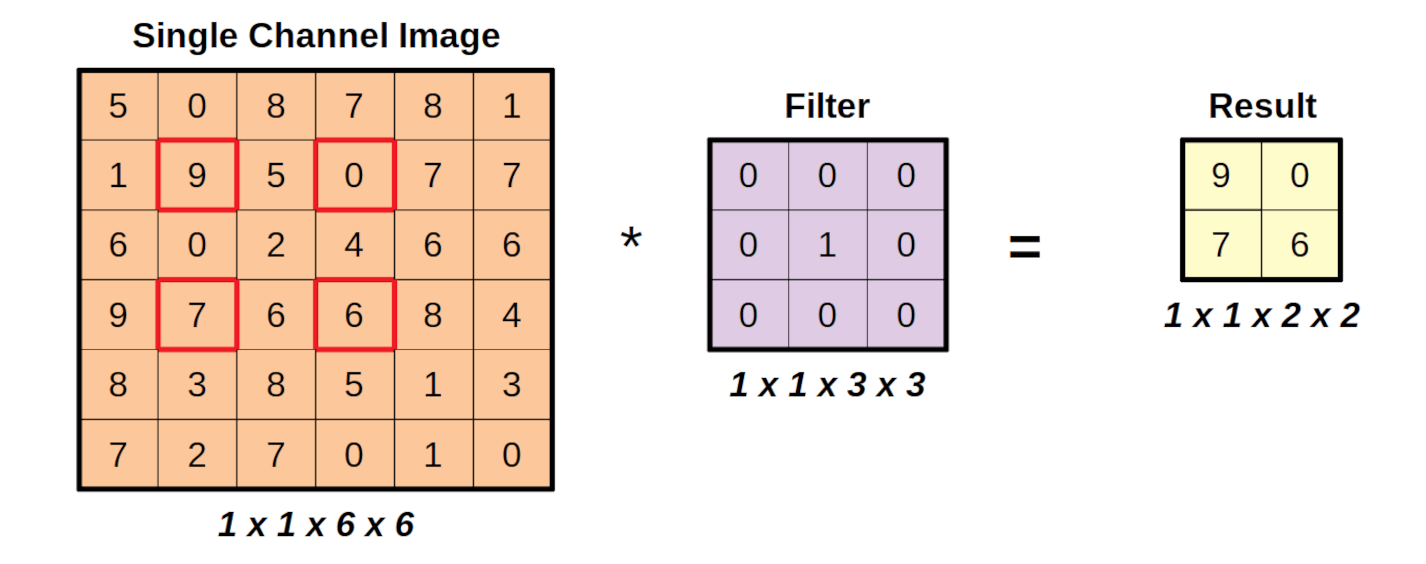

In [16]:
convolved_stride2 = F.conv2d(image, kernel_identity, stride=2)
convolved_stride2

tensor([[[[9., 0.],
          [7., 6.]]]])

## **Padding**

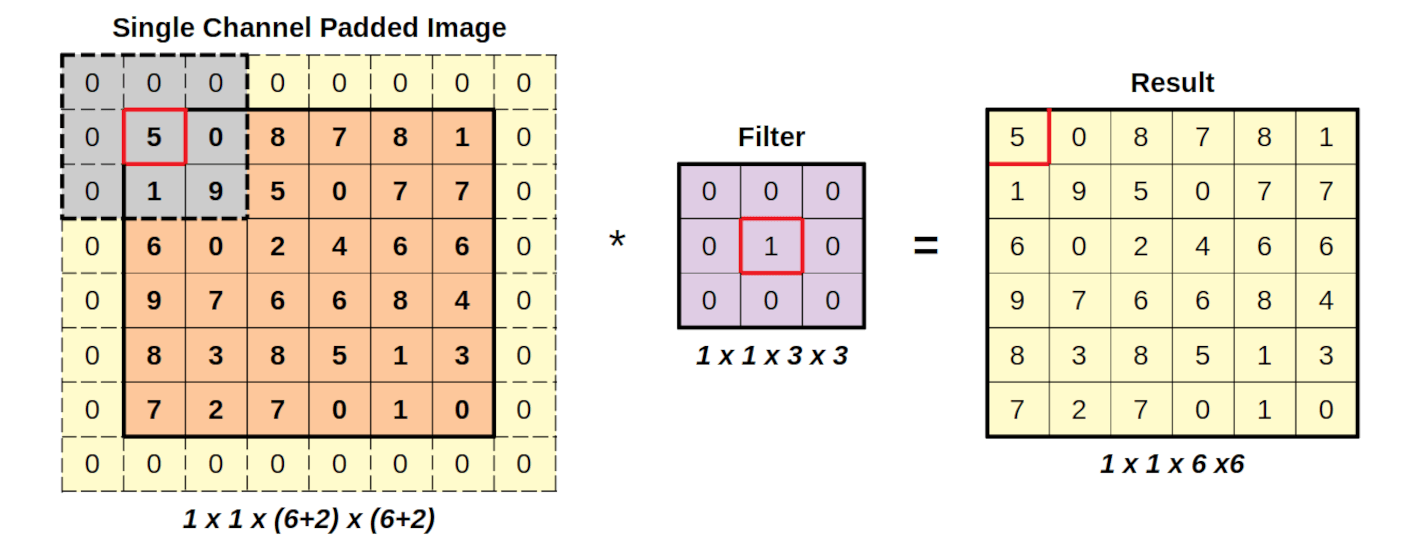

In [17]:
constant_padder = nn.ConstantPad2d(padding=1, value=0)
constant_padder(image)

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 5., 0., 8., 7., 8., 1., 0.],
          [0., 1., 9., 5., 0., 7., 7., 0.],
          [0., 6., 0., 2., 4., 6., 6., 0.],
          [0., 9., 7., 6., 6., 8., 4., 0.],
          [0., 8., 3., 8., 5., 1., 3., 0.],
          [0., 7., 2., 7., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

In [18]:
padded = F.pad(image, pad=(1, 1, 1, 1), mode='constant', value=0)

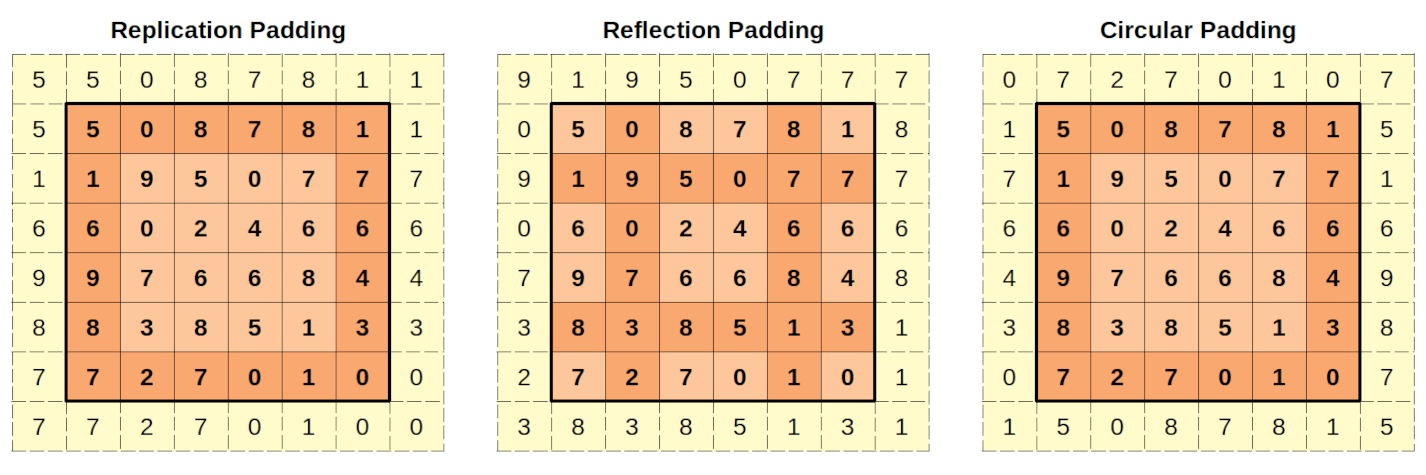

In [19]:
replication_padder = nn.ReplicationPad2d(padding=1)
replication_padder(image)

tensor([[[[5., 5., 0., 8., 7., 8., 1., 1.],
          [5., 5., 0., 8., 7., 8., 1., 1.],
          [1., 1., 9., 5., 0., 7., 7., 7.],
          [6., 6., 0., 2., 4., 6., 6., 6.],
          [9., 9., 7., 6., 6., 8., 4., 4.],
          [8., 8., 3., 8., 5., 1., 3., 3.],
          [7., 7., 2., 7., 0., 1., 0., 0.],
          [7., 7., 2., 7., 0., 1., 0., 0.]]]])

In [20]:
reflection_padder = nn.ReflectionPad2d(padding=1)
reflection_padder(image)

tensor([[[[9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 5., 0., 8., 7., 8., 1., 8.],
          [9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 6., 0., 2., 4., 6., 6., 6.],
          [7., 9., 7., 6., 6., 8., 4., 8.],
          [3., 8., 3., 8., 5., 1., 3., 1.],
          [2., 7., 2., 7., 0., 1., 0., 1.],
          [3., 8., 3., 8., 5., 1., 3., 1.]]]])

In [21]:
F.pad(image, pad=(1, 1, 1, 1), mode='circular')

tensor([[[[0., 7., 2., 7., 0., 1., 0., 7.],
          [1., 5., 0., 8., 7., 8., 1., 5.],
          [7., 1., 9., 5., 0., 7., 7., 1.],
          [6., 6., 0., 2., 4., 6., 6., 6.],
          [4., 9., 7., 6., 6., 8., 4., 9.],
          [3., 8., 3., 8., 5., 1., 3., 8.],
          [0., 7., 2., 7., 0., 1., 0., 7.],
          [1., 5., 0., 8., 7., 8., 1., 5.]]]])

## **A REAL Filter**

In [22]:
edge = np.array(
    [[[[0, 1, 0],
       [1, -4, 1],
       [0, 1, 0]]]]
)
kernel_edge = torch.as_tensor(edge).float()
kernel_edge.shape

torch.Size([1, 1, 3, 3])

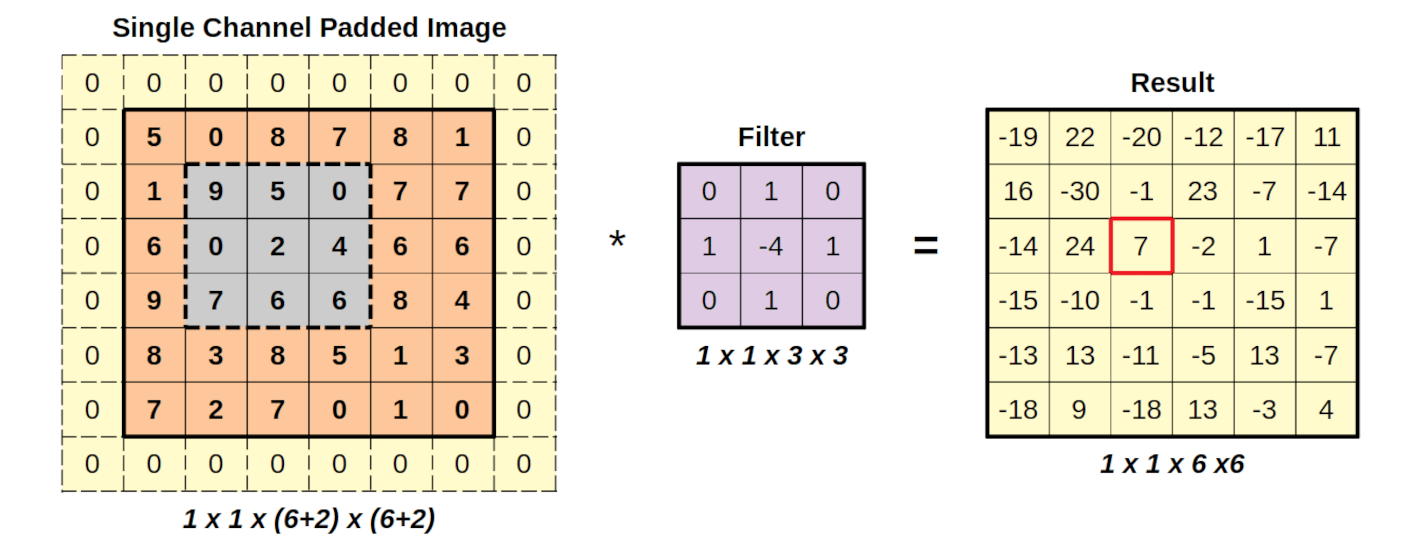

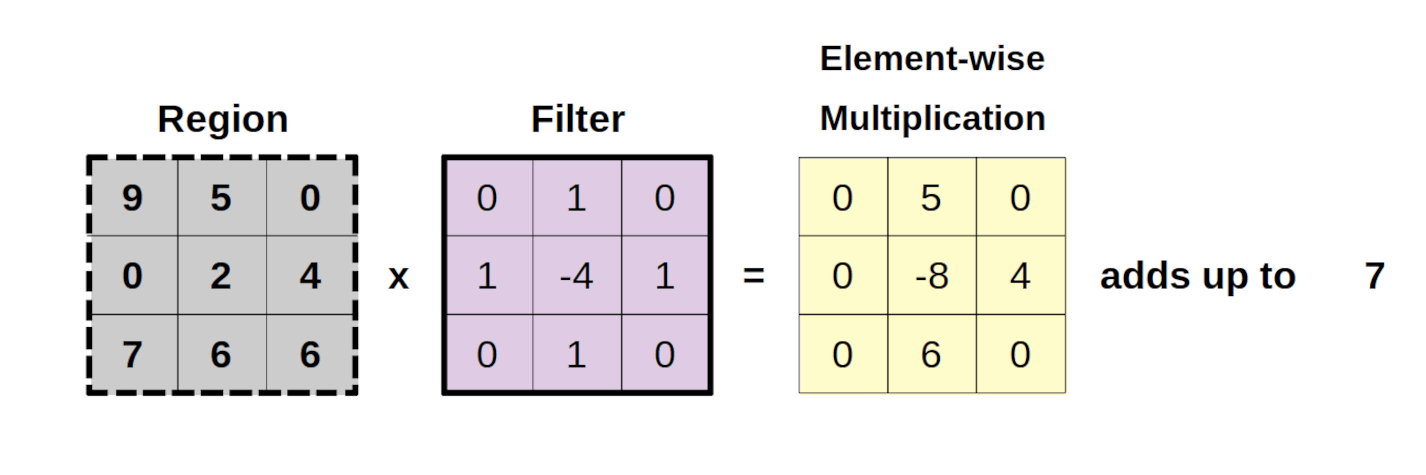

In [23]:
padded = F.pad(image, (1, 1, 1, 1), mode='constant', value=0)
conv_padded = F.conv2d(padded, kernel_edge, stride=1)

## **Pooling**

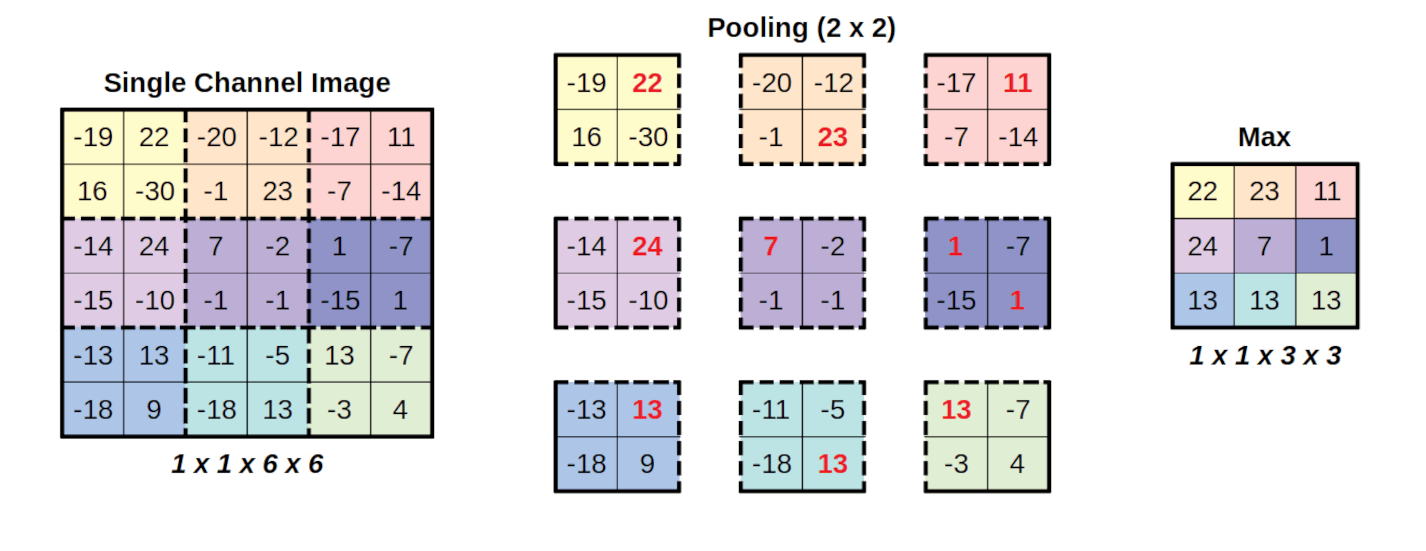

In [24]:
pooled = F.max_pool2d(conv_padded, kernel_size=2)
pooled

tensor([[[[22., 23., 11.],
          [24.,  7.,  1.],
          [13., 13., 13.]]]])

In [25]:
maxpool4 = nn.MaxPool2d(kernel_size=4)
pooled4 = maxpool4(conv_padded)
pooled4

tensor([[[[24.]]]])

In [26]:
F.max_pool2d(conv_padded, kernel_size=3, stride=1)

tensor([[[[24., 24., 23., 23.],
          [24., 24., 23., 23.],
          [24., 24., 13., 13.],
          [13., 13., 13., 13.]]]])

## **Flattening**

In [27]:
flattened = nn.Flatten()(pooled)
flattened

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

In [28]:
pooled.view(1, -1)

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

## **Typical Architecture**

### **LeNet5**

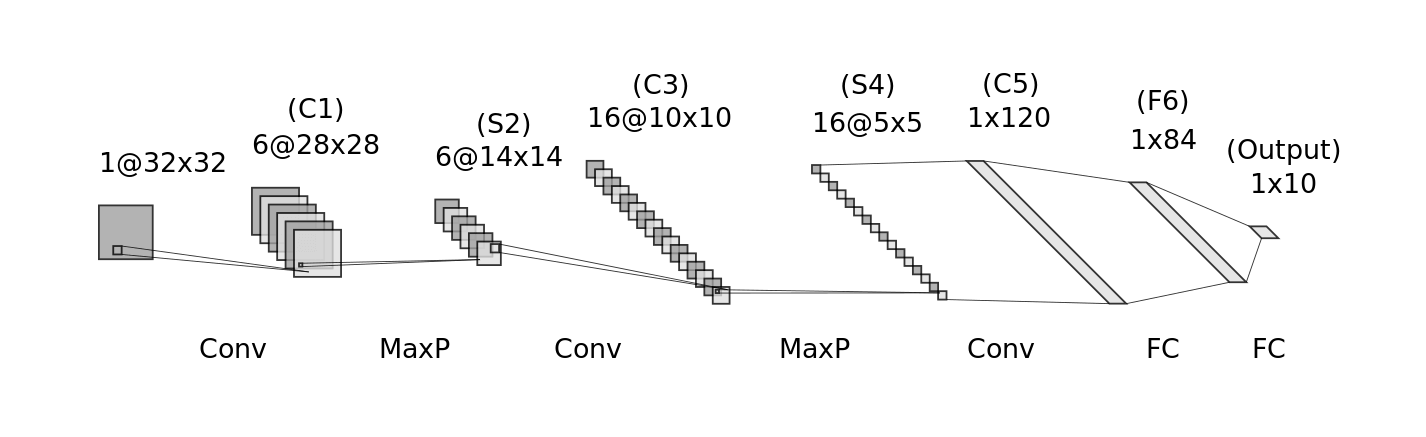

**Source: Generated using Alexander Lenail's http://alexlenail.me/NN-SVG/ and adapted by the author. For more details, see LeCun, Y., et al (1998). http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf. Proceedings of the IEEE,86(11), 2278–2324**


In [29]:
lenet = nn.Sequential()

# Featurizer
# Block 1: 1@28x28 -> 6@28x28 -> 6@14x14
lenet.add_module('C1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2))
lenet.add_module('func1', nn.ReLU())
lenet.add_module('S2', nn.MaxPool2d(kernel_size=2))

# Block 2: 6@14x14 -> 16@10x10 -> 16@5x5
lenet.add_module('C3', nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5))
lenet.add_module('func2', nn.ReLU())
lenet.add_module('S4', nn.MaxPool2d(kernel_size=2))

# Block 3: 16@5x5 -> 120@1x1
lenet.add_module('C5', nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5))
lenet.add_module('func2', nn.ReLU())
# Flattening
lenet.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
lenet.add_module('F6', nn.Linear(in_features=120, out_features=84))
lenet.add_module('func3', nn.ReLU())
# Output Layer
lenet.add_module('OUTPUT', nn.Linear(in_features=84, out_features=10))